---
---

# **Analysis of the audio results with the window slide technique**

In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/WS_analysis_results.csv

--2022-07-19 18:03:02--  https://perso.esiee.fr/~gueurett/LV_Research/WS_analysis_results.csv
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958567 (936K) [text/csv]
Saving to: ‘WS_analysis_results.csv’

WS_analysis_results 100%[===================>] 936.10K  1.65MB/s    in 0.6s    

2022-07-19 18:03:03 (1.65 MB/s) - ‘WS_analysis_results.csv’ saved [958567/958567]



In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/Acoustic_Analysis_Results.csv

--2022-07-19 18:03:05--  https://perso.esiee.fr/~gueurett/LV_Research/Acoustic_Analysis_Results.csv
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68157 (67K) [text/csv]
Saving to: ‘Acoustic_Analysis_Results.csv’

Acoustic_Analysis_R 100%[===================>]  66.56K   362KB/s    in 0.2s    

2022-07-19 18:03:06 (362 KB/s) - ‘Acoustic_Analysis_Results.csv’ saved [68157/68157]



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras import layers, initializers
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.ensemble import RandomForestClassifier

In [ ]:
prints = False

data = pd.read_csv('WS_analysis_results.csv', delimiter=',', dtype=None, encoding=None)
data = data.rename(columns={'MOMENTS': 'Filename'}) # rename the MOMENTS column to the filename column

data_2 = pd.read_csv('Acoustic_Analysis_Results.csv', delimiter=',', dtype=None, encoding=None)
data_2 = data_2.rename(columns={'Unnamed: 0': 'Filename'}) # rename the not-named column to the filename column
data_2 = data_2.drop(columns=['Filename'])
data_2 = data_2.fillna(data_2.mean())

for column_name in data_2.columns:
  data_2[column_name] = (data_2[column_name] - np.mean(data_2[column_name])) / np.std(data_2[column_name])
data_2 = data_2.to_numpy()

n_samples = 200
n_windows = 14
n_features = 35

dataset = np.ones(shape=(n_samples, n_windows+1, n_features))
labels  = np.zeros(shape=(n_samples))

for column_name in data.columns:
  if column_name == 'Filename': continue
  data[column_name] = (data[column_name] - np.mean(data[column_name])) / np.std(data[column_name])

for index, row in data.iterrows():

  filename = row['Filename'][:-4]
  if prints: print("filename without wav: ", filename)

  label, n_sample, n_part = filename.split('_')
  n_sample = int(n_sample)
  n_part   = int(n_part)

  if prints:
    print("label: ", label)
    print("n_sample: ", n_sample)
    print("n_part: ", n_part)

  if n_part == 9 and label == 'I':    # there are 14 parts but the index 9 is the last one because in the csv file, the filenames are sorted such as 9 is at the end
      labels[n_sample] = 1

  row = data.iloc[index].to_numpy()[1:]
  if prints:
    print("row.shape: ", row.shape)
    print("dataset.shape:  ", dataset.shape)
    print("dataset[n_sample, n_part, :].shape:  ", dataset[n_sample, n_part, :].shape, '\n\n')
  dataset[n_sample, n_part, :] = row

for index in range(n_samples):
  dataset[index, -1, :] = data_2[index]

rng     = np.random.default_rng() # shuffle time
shuffle = rng.choice(n_samples, size=(n_samples), replace=False)
data    = dataset[shuffle]
labels  = labels[shuffle]

print("---------------------------------")
print("|  dataset.shape:", dataset.shape, "|")
print("|  labels.shape: ", labels.shape, "       |")
print("---------------------------------")

---------------------------------
|  dataset.shape: (200, 15, 35) |
|  labels.shape:  (200,)        |
---------------------------------


In [ ]:
def plot_things(history):
  fig = plt.figure(figsize=(10, 8))
  plt.subplot(2,1,1)
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  fig = plt.figure(figsize=(10, 8))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def get_model_1(input_shape=(15, 35), n_neurons=50, dropout_rate=0.2, learning_rate=0.0001, beta_1=0.2):

  model = tf.keras.Sequential()

  model.add(layers.Flatten(input_shape=input_shape))

  model.add(layers.Dense(n_neurons))
  model.add(layers.ReLU())
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(1, activation='sigmoid'))

  optimizer = Adam(learning_rate, beta_1=beta_1)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

model = get_model_1()
model.summary()

Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_114 (Flatten)       (None, 525)               0         
                                                                 
 dense_290 (Dense)           (None, 50)                26300     
                                                                 
 re_lu_176 (ReLU)            (None, 50)                0         
                                                                 
 dropout_176 (Dropout)       (None, 50)                0         
                                                                 
 dense_291 (Dense)           (None, 1)                 51        
                                                                 
Total params: 26,351
Trainable params: 26,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(dataset, labels, epochs=200, batch_size=10, validation_split=0.4)

Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 0.7730 - binary_accuracy: 0.5333 - val_loss: 0.5188 - val_binary_accuracy: 0.7500
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 0.7254 - binary_accuracy: 0.5500 - val_loss: 0.5152 - val_binary_accuracy: 0.7500
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 0.6744 - binary_accuracy: 0.5750 - val_loss: 0.5138 - val_binary_accuracy: 0.7500
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.7203 - binary_accuracy: 0.6000 - val_loss: 0.5107 - val_binary_accuracy: 0.7750
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.6613 - binary_accuracy: 0.6583 - val_loss: 0.5069 - val_binary_accuracy: 0.7750
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.6418 - binary_accuracy: 0.6333 - val_loss: 0.5057 - val_binary_accuracy: 0.7875
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - lo

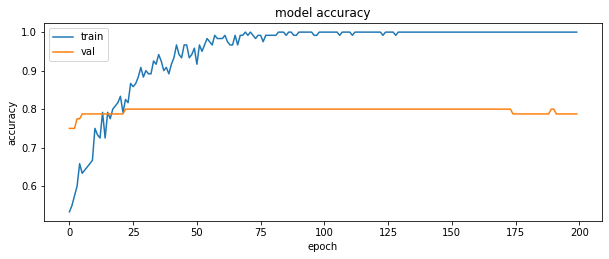

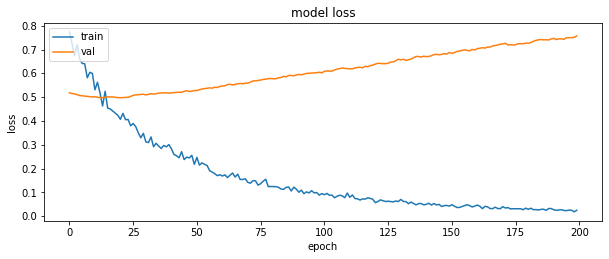

In [ ]:
plot_things(history)

In [ ]:
number_splits = 8
number_runs   = 3
results_acc   = np.zeros(shape=(number_runs, number_splits))
results_loss  = np.zeros(shape=(number_runs, number_splits))


for run in range(number_runs):
  
  print("\n\n\nDoing the run number ", run+1)
  kfold = KFold(n_splits=number_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for split,(fold_train, fold_test) in enumerate(kfold.split(dataset, labels)):

    model = get_model_1()
    print("Training the fold number ", fold_no,"\n")
    history = model.fit(dataset[fold_train], labels[fold_train], batch_size=10, epochs=25)

    scores = model.evaluate(dataset[fold_test], labels[fold_test], verbose=0)
    print("For the fold number ",  fold_no, ":\nloss = ", scores[0], "\naccuracy = ", scores[1]*100,"%")
    results_acc[run][split] = scores[1] * 100
    results_loss[run][split] = scores[0]

    # Increase fold number
    fold_no = fold_no + 1


results_acc = np.mean(results_acc, axis=1)
results_loss = np.mean(results_loss, axis=1)

results_acc = np.mean(results_acc)
results_loss = np.mean(results_loss)

print("\n\n\nWe obtain the following results:\nmean accuracy: ",results_acc,"%", "\nmean loss:",results_loss)




Doing the run number  1
Training the fold number  1 

Epoch 1/25
18/18 [==============================] - 1s 4ms/step - loss: 0.6598 - binary_accuracy: 0.6400
Epoch 2/25
18/18 [==============================] - 0s 4ms/step - loss: 0.6566 - binary_accuracy: 0.6400
Epoch 3/25
18/18 [==============================] - 0s 4ms/step - loss: 0.6183 - binary_accuracy: 0.6571
Epoch 4/25
18/18 [==============================] - 0s 4ms/step - loss: 0.6425 - binary_accuracy: 0.6800
Epoch 5/25
18/18 [==============================] - 0s 5ms/step - loss: 0.5965 - binary_accuracy: 0.6971
Epoch 6/25
18/18 [==============================] - 0s 5ms/step - loss: 0.5994 - binary_accuracy: 0.7143
Epoch 7/25
18/18 [==============================] - 0s 4ms/step - loss: 0.5712 - binary_accuracy: 0.7143
Epoch 8/25
18/18 [==============================] - 0s 8ms/step - loss: 0.5518 - binary_accuracy: 0.7143
Epoch 9/25
18/18 [==============================] - 0s 4ms/step - loss: 0.5411 - binary_accuracy: 0.725

---
**CNN**

In [ ]:
def get_model_2():

  model = tf.keras.Sequential()

  model.add(layers.Input(shape=(14,35)))

  model.add(layers.Conv2D())

---
---
# **Random Forest Classifier**

(200, 15, 35)
(200, 525)
0.68
[1.04704749e-03 2.58518819e-03 9.03176307e-04 8.70006118e-04
 7.03001350e-04 6.28901473e-04 9.61448401e-04 1.99887482e-03
 1.08921202e-03 8.00918442e-04 9.96865324e-04 1.51063506e-03
 3.39739095e-04 2.59466584e-03 3.47204574e-03 1.49312767e-03
 1.31004004e-03 3.88875197e-03 1.30295614e-03 5.71978337e-04
 1.91133198e-03 7.76733225e-04 1.38774205e-03 2.87925595e-03
 4.54528492e-04 1.04233399e-03 1.21895665e-04 3.25053681e-03
 3.51561591e-04 1.36092943e-03 1.17563126e-03 1.21624907e-03
 1.94431824e-03 5.10532418e-03 2.54129531e-03 7.44081141e-04
 1.03806475e-03 1.23885207e-03 1.74516654e-03 5.07392403e-04
 9.39833843e-04 7.62885748e-04 2.95045014e-03 6.30407860e-04
 1.79255102e-03 1.55880507e-03 1.03109878e-03 5.90842203e-04
 1.13939781e-03 1.19798702e-03 1.70469938e-03 1.21006116e-03
 3.10534152e-03 1.54909297e-03 3.96408529e-04 1.07484457e-03
 1.84965157e-03 2.17161590e-03 1.60954887e-03 6.86910285e-04
 2.49017254e-03 1.58995952e-04 1.36569301e-03 4.6336060

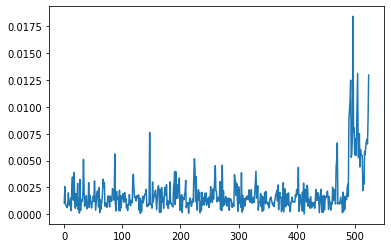

In [ ]:
data_rfc = dataset.reshape(( dataset.shape[0], dataset.shape[1]*dataset.shape[2] ))
print(dataset.shape)
print(data_rfc.shape)

rfc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', oob_score=True, random_state=8)
rfc.fit(data_rfc, labels)

print(rfc.oob_score_)
print(rfc.feature_importances_)
plt.plot(rfc.feature_importances_)